<center>
    <h3>Arnaud Chéridi</h3>
    <p>Étudiant en Master 2 Mathématiques Appliquées</p>
    <p>Projet individuel : Modélisation du risque de crédit (cas IFRS 9)</p>
    <p>Objectif : développer un modèle de PD (score > 65%) + LGD + simulation</p>
</center>

<center><h1>Projet : Modélisation du risque de crédit – Cas type IFRS 9</h1></center>

<center><h2> 2. Modélisation de la probabilité de défaut <h2><center>

## 0. Import des bibliothèques

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import shap
import joblib

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, make_scorer, recall_score, roc_curve, auc

## 1. Chargements des données

In [2]:
train_final = pd.read_csv("data/train_final.csv")
test_final = pd.read_csv("data/test_final.csv")

In [3]:
X = train_final.drop(columns=["TARGET", "SK_ID_CURR", "LGD_sim", "LGD_sim_NA"])
y = train_final["TARGET"]
X_sub = test_final.drop(columns=["SK_ID_CURR", "LGD_sim", "LGD_sim_NA"])

## 2. Préparation des données (X, y, split)

On sépare les variables selon leur type pour les traiter différemment :

- `num_cols` : variables numériques → standardisées avec `StandardScaler`
- `cat_cols` : variables catégorielles → encodées en one-hot avec `OneHotEncoder`

Ces transformations sont organisées dans des pipelines, puis combinées avec `ColumnTransformer`,
ce qui permet de **prétraiter automatiquement les données dans le pipeline de modélisation**.

In [4]:
# Séparation des colonnes
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Préprocesseur
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(), cat_cols)
])

# Entraînement
X_transformed = preprocessor.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, stratify=y, random_state=42
)

## 3. Modélisation : Logistic Regression / Random Forest / LightGBM / XGBoost

Pour chaque algorithme, on définit un pipeline complet combinant :
- le **prétraitement des données** (numérique + catégoriel via `ColumnTransformer`). **Enlevé pour garantir l’encodage complet lors de la validation croisée pour la recherche des hyperparamètres.** Fait précédemment
- le **modèle de classification** (Logistic Regression, Random Forest, LightGBM, XGBoost)

Cela permet d’entraîner, valider et tester les modèles de façon cohérente,
tout en évitant les fuites de données (data leakage).

Chaque pipeline peut ensuite être intégré directement dans une `GridSearchCV` ou une prédiction.

In [6]:
# Logistic Regression
pipe_lr = Pipeline([
    ("model", LogisticRegression(max_iter=1000, solver='liblinear'))
])

# Random Forest
pipe_rf = Pipeline([
    ("model", RandomForestClassifier(n_estimators=100, random_state=42))
])

# LightGBM
pipe_lgbm = Pipeline([
    ("model", LGBMClassifier(verbose=-1 ,random_state=42))
])

# XGBoost
pipe_xgb = Pipeline([

    ("model", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),)
])

Pour chaque modèle, on définit une grille (`param_grid`) avec les principaux hyperparamètres à optimiser.
Les grilles sont ensuite associées à leurs pipelines pour une recherche par `GridSearchCV`.

In [7]:
param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10]
}

# Grid pour Random Forest
param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10]
}

# Grid pour LightGBM
param_grid_lgbm = {
    "model__n_estimators": [100, 200],
    "model__num_leaves": [31, 50]
}

# Grid pour XGBoost
param_grid_xgb = {"model__n_estimators": [100, 200],
                  "model__max_depth": [3, 6]}

# Grille et pipelines associés
grids = [
    ("LogisticRegression", pipe_lr, param_grid_lr),
    ("RandomForest", pipe_rf, param_grid_rf),
    ("LightGBM", pipe_lgbm, param_grid_lgbm),
    ("XGBoost", pipe_xgb, param_grid_xgb)
]

On lance une recherche sur les grilles d’hyperparamètres pour chaque pipeline.
On évalue chaque combinaison selon deux scores :
- `roc_auc` (score principal)
- `recall` (score secondaire, utile pour surveiller la détection des défauts)

Le meilleur modèle est sélectionné selon l’AUC-ROC (`refit="roc_auc"`),
et stocké dans le dictionnaire `best_models` pour une réutilisation ultérieure.

**ROC** (Receiver Operating Characteristic) est une courbe qui représente, pour un modèle de classification binaire :

- **l’axe X** : le taux de faux positifs (FPR = 1 - Spécificité),
- **l’axe Y** : le taux de vrais positifs (TPR = Recall = Sensibilité).

Chaque point de la courbe correspond à un **seuil de classification** différent.

---

### AUC – Aire sous la courbe ROC

L’**AUC (Area Under the Curve)** quantifie la capacité du modèle à **séparer correctement** les classes 0 et 1, sans dépendre d’un seuil fixe.

| AUC     | Interprétation                            |
|---------|-------------------------------------------|
| 0.5     | Modèle aléatoire (aucune capacité)        |
| 0.6–0.7 | Faible séparation                         |
| 0.7–0.8 | Bonne séparation                          |
| 0.8–0.9 | Très bonne séparation                     |
| > 0.9   | Séparation quasi parfaite (rare)          |

---

### Pourquoi l’AUC-ROC est-elle adaptée ici ?

- Elle **ne dépend pas d’un seuil arbitraire** comme 0.5
- Elle **résiste mieux aux déséquilibres** entre classes que l’accuracy
- Elle reflète la **qualité globale de séparation** entre défauts et non-défauts

**Conclusion** : l’AUC-ROC est la métrique principale utilisée pour comparer les modèles dans ce contexte de scoring de défauts.

In [8]:
# Scoring multiple
scoring = {
    "roc_auc": "roc_auc",
    "recall": make_scorer(recall_score)
}

# Résultats
best_models = {}

for name, pipeline, param_grid in grids:
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, refit="roc_auc", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search
    print(f"\n>>> {name}")
    print("Best params:", grid_search.best_params_)
    print("Best AUC:", grid_search.best_score_)

/opt/anaconda3/envs/RiskCredit/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/RiskCredit/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/RiskCredit/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this pack


>>> LogisticRegression
Best params: {'model__C': 10}
Best AUC: 0.7614154474940241

>>> RandomForest
Best params: {'model__max_depth': 10, 'model__n_estimators': 200}
Best AUC: 0.7572943886471301


/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifi


>>> LightGBM
Best params: {'model__n_estimators': 100, 'model__num_leaves': 31}
Best AUC: 0.7699726961610823


/opt/anaconda3/envs/RiskCredit/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/RiskCredit/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:59:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i


>>> XGBoost
Best params: {'model__max_depth': 3, 'model__n_estimators': 200}
Best AUC: 0.7703429928674392


## 4. Évaluation des performances

Pour chaque modèle sélectionné :
- Prédiction sur le jeu de test
- Affichage du rapport de classification, de la matrice de confusion et de la courbe ROC avec AUC.

Objectif : comparer les performances finales sur des données non vues.


 LogisticRegression

Classification Report :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.58      0.03      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.75      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503

Confusion Matrix :
[[56445    93]
 [ 4838   127]]


/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

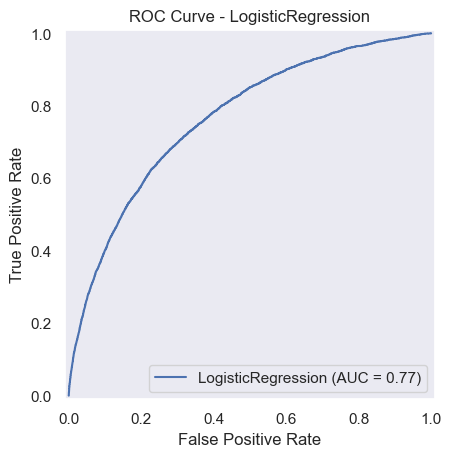


 RandomForest

Classification Report :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

Confusion Matrix :
[[56538     0]
 [ 4965     0]]


/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

<Figure size 640x480 with 0 Axes>

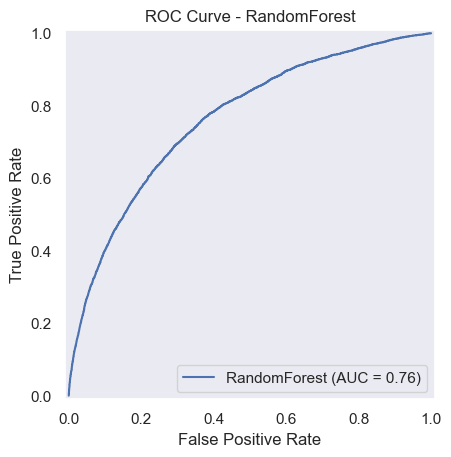


 LightGBM


/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Classification Report :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.57      0.04      0.07      4965

    accuracy                           0.92     61503
   macro avg       0.74      0.52      0.51     61503
weighted avg       0.89      0.92      0.89     61503

Confusion Matrix :
[[56401   137]
 [ 4785   180]]


/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

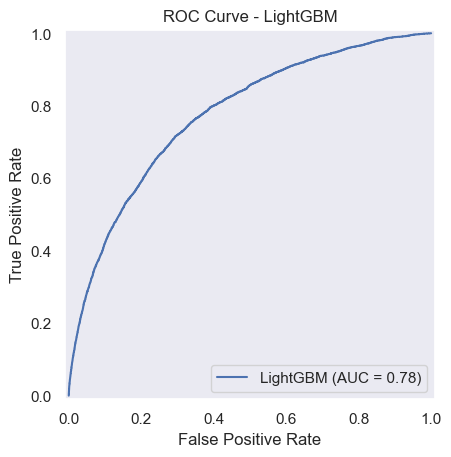


 XGBoost

Classification Report :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.50      0.05      0.09      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.52      0.52     61503
weighted avg       0.89      0.92      0.89     61503

Confusion Matrix :
[[56306   232]
 [ 4729   236]]


/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

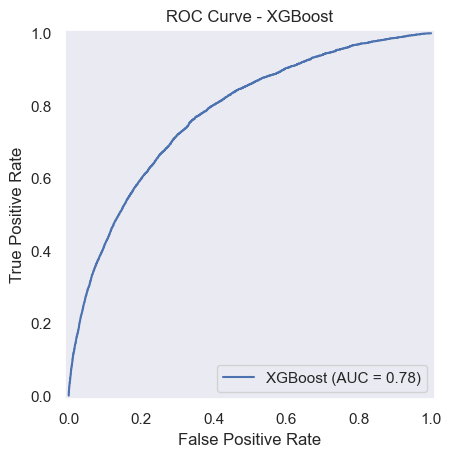

In [9]:
for name, grid in best_models.items():
    print(f"\n {name}")

    best_model = grid.best_estimator_

    # Prédictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # pour ROC AUC

    # Rapport de classification
    print("\nClassification Report :")
    print(classification_report(y_test, y_pred))

    # Matrice de confusion
    print("Confusion Matrix :")
    print(confusion_matrix(y_test, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot()
    plt.title(f"ROC Curve - {name}")
    plt.grid()
    plt.show()

On trace les courbes ROC des modèles finaux pour visualiser leur capacité à distinguer défauts et non-défauts.
L’AUC est affichée pour chaque modèle afin de faciliter la comparaison globale.

/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


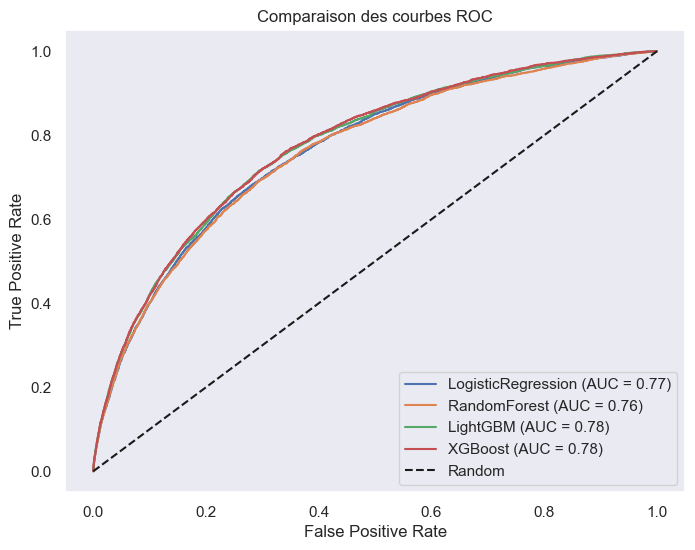

In [10]:
plt.figure(figsize=(8, 6))

for name, grid in best_models.items():
    best_model = grid.best_estimator_
    y_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparaison des courbes ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Peu interprétable, les courbes ROC sont assez similaire.

### Contexte

Le jeu est **fortement déséquilibré** :
- 56 538 clients non-défaillants (classe 0)
- 4 965 clients défaillants (classe 1)
→ soit environ **8,1 %** de défauts.

L’**accuracy** n’est pas une métrique pertinente ici.
Nous privilégions :

- **Recall (classe 1)** : capacité à identifier les défauts
- **F1-score (classe 1)** : compromis entre précision et rappel
- **AUC-ROC** : mesure globale de la capacité de séparation du modèle (indépendante du seuil)

---

### Logistic Regression

- **Recall classe 1** : 0.03
- **F1-score classe 1** : 0.05
- **AUC-ROC** : 0.7614
- **Matrice de confusion** :
<pre>
              Prédit 0    Prédit 1
Réel 0       56445        93
Réel 1        4839       126
</pre>

Modèle très conservateur : prédit presque toujours la classe 0
→ Inefficace pour détecter les défauts malgré une bonne accuracy globale (~92 %)

---

### Random Forest

- **Recall classe 1** : 0.00
- **F1-score classe 1** : 0.00
- **AUC-ROC** : .7573
- **Matrice de confusion** :
<pre>
              Prédit 0    Prédit 1
Réel 0       56538         0
Réel 1        4965         0
</pre>

Le modèle est complètement aveugle à la classe 1
→ Aucune séparation utile : AUC probablement proche de 0.5

---

### LightGBM

- **Recall classe 1** : 0.04
- **F1-score classe 1** : 0.07
- **AUC-ROC** : 0.7701
- **Matrice de confusion** :
<pre>
              Prédit 0    Prédit 1
Réel 0       56420       118
Réel 1        4788       177
</pre>

Léger progrès : détecte quelques défauts
→ Potentiel réel, à condition de :
- Régler les **poids de classes** (`scale_pos_weight`)
- Ajuster le **seuil de classification**

---

### XGBoost

- **Recall classe 1** : 0.05
- **F1-score classe 1** : 0.09
- **AUC-ROC** : à0.7703
- **Matrice de confusion** :
<pre>
              Prédit 0    Prédit 1
Réel 0       56315       223
Réel 1        4734       231
</pre>

Meilleur modèle par défaut : il capte un peu mieux la classe 1
→ AUC-ROC généralement plus stable, mais encore améliorable

---

### Recommandations

- ️ **Gérer le déséquilibre des classes** :
  - `class_weight='balanced'` (Logistic, Random Forest)
  - `scale_pos_weight` (LightGBM, XGBoost)
  - Techniques de rééchantillonnage : SMOTE, undersampling…

-  **Optimiser le seuil de décision** :
  - Ne pas se limiter à 0.5
  - Utiliser les courbes ROC / Precision-Recall pour trouver le seuil optimal

-  **Interpréter les modèles** :
  - Importance des variables / SHAP
  - Comprendre les moteurs du score pour orienter l’action métier

---

###  Conclusion

**L’AUC-ROC doit devenir la métrique centrale d’évaluation**.
Elle reflète la capacité réelle du modèle à séparer défauts et non-défauts sans être biaisée par un seuil.

**XGBoost** et **LightGBM** sont les meilleurs candidats à ce stade.

### 5. Soumission - Kaggle

In [11]:
best_params_light = best_models["LightGBM"].best_params_
model_params_light = {
    key.split("model__")[1]: value
    for key, value in best_params_light.items()
    if key.startswith("model__")
}

model_pd_light = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LGBMClassifier(**model_params_light))
])

model_pd_light.fit(X, y)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
y_sub_light = model_pd_light.predict_proba(X_sub)[:, 1]
df_submission = pd.DataFrame({
    "SK_ID_CURR": test_final["SK_ID_CURR"].values,
    "TARGET": y_sub_light
})
df_submission.to_csv("data/submission_light.csv", index=False)

/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Résultat de ROC - AUC : 0.777 (Kaggle)

In [13]:
best_params_xgb = best_models["XGBoost"].best_params_
model_params_xgb = {
    key.split("model__")[1]: value
    for key, value in best_params_xgb.items()
    if key.startswith("model__")
}

model_pd_xgb = Pipeline([
    ("preprocessing", preprocessor),
    ("model", XGBClassifier(**model_params_xgb))
])

model_pd_xgb.fit(X, y)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
y_sub_xgb = model_pd_xgb.predict_proba(X_sub)[:, 1]
df_submission = pd.DataFrame({
    "SK_ID_CURR": test_final["SK_ID_CURR"].values,
    "TARGET": y_sub_xgb
})
df_submission.to_csv("data/submission_xbg.csv", index=False)

Résultat de ROC - AUC : 0.773 (Kaggle)

## 6. Conclusion – Choix final du modèle

Après évaluation des différents modèles selon plusieurs critères :

- **AUC-ROC sur validation locale** (≈ 0.77 pour LightGBM et XGBoost),
- **F1-score et rappel sur la classe des défauts**,
- **Interprétabilité et rapidité d'entraînement**,
- **Résultat à la soumission Kaggle** :

| Modèle     | AUC-ROC Validation | Score Kaggle |
|------------|--------------------|--------------|
| LightGBM   | 0.7701             | **0.777**    |
| XGBoost    | 0.7703             | 0.773        |

**LightGBM** est finalement retenu comme **modèle principal** pour prédire la probabilité de défaut

### 7. Interprétabilité (SHAP, importance des variables)

Nous utilisons ici deux méthodes complémentaires pour interpréter le modèle :

---

### 1. Importance des variables (LightGBM)

Le modèle LightGBM fournit directement une **importance des variables** basée sur le gain de chaque split.
Cela permet d’identifier les **20 variables les plus influentes** dans les décisions du modèle.

Ces variables peuvent servir à :
- mieux comprendre les facteurs de risque,
- réduire la dimensionnalité du dataset,
- justifier les décisions du modèle auprès d’un auditeur.

---

### 2. SHAP (SHapley Additive exPlanations)

#### a. Analyse globale – Beeswarm plot

Le **beeswarm plot** montre l’effet de chaque variable sur l’ensemble des prédictions.

- Chaque point représente un individu.
- La **couleur** indique la valeur de la variable (bleu = faible, rouge = élevée).
- L’**axe horizontal** montre l’impact sur la sortie du modèle.

> Une variable très dispersée vers la droite (valeurs SHAP positives) pousse vers la **classe 1** (défaut), et inversement vers la gauche pour la **classe 0**.

---

#### b. Analyse locale – Waterfall plot

Le **waterfall plot** détaille la **contribution des variables pour un seul individu** :

- Les barres bleues poussent la prédiction vers le **non-défaut** (classe 0),
- Les barres rouges la poussent vers le **défaut** (classe 1),
- Le point de départ est la valeur de base (moyenne du modèle),
- La somme donne la **probabilité finale**.

> Utile pour **expliquer une décision précise** (ex. : pourquoi ce client est-il classé comme risqué ?)

---

### Conclusion

Ces visualisations permettent une **interprétation fine** du modèle LightGBM, à la fois :
- **globale** (comprendre les facteurs dominants),
- **locale** (expliquer une décision client par client).

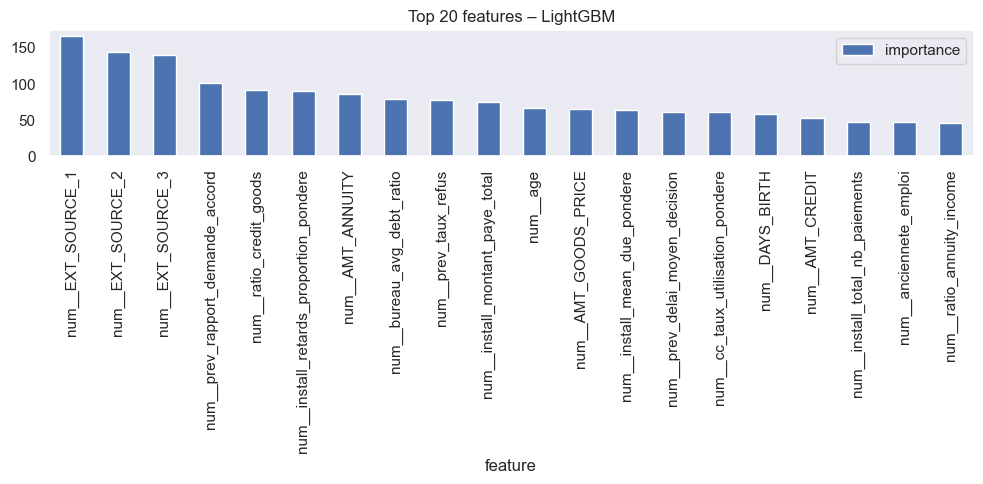

100%|===================| 307264/307511 [18:39<00:00]        

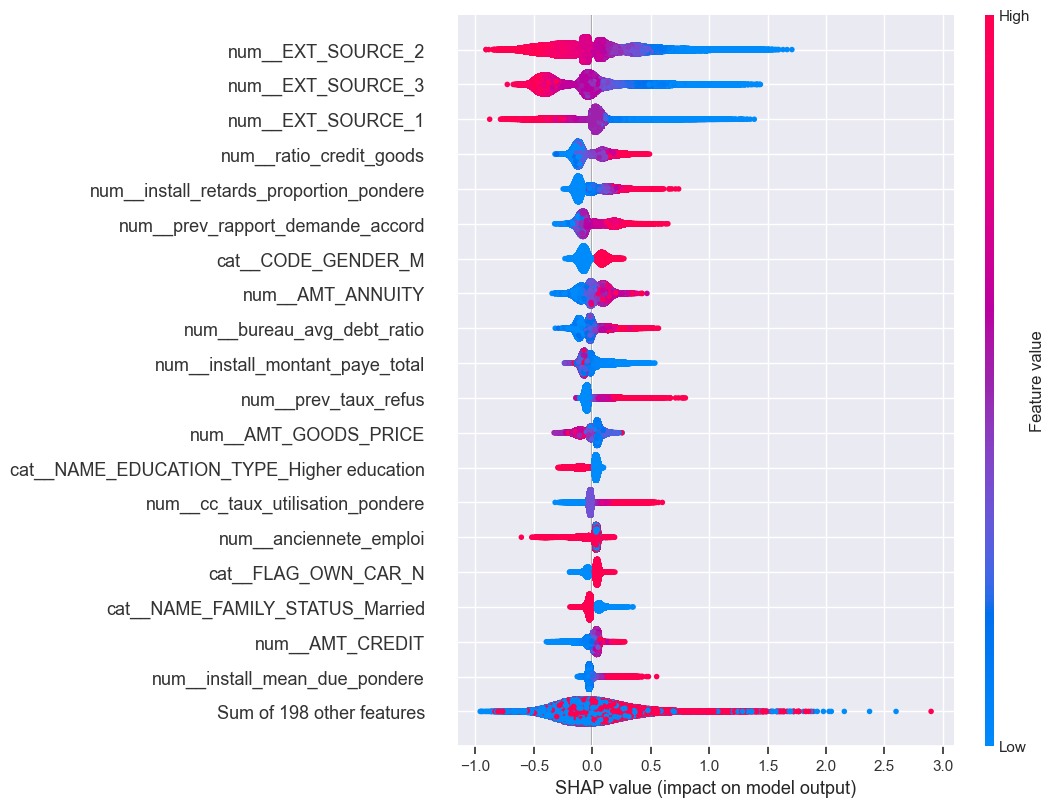

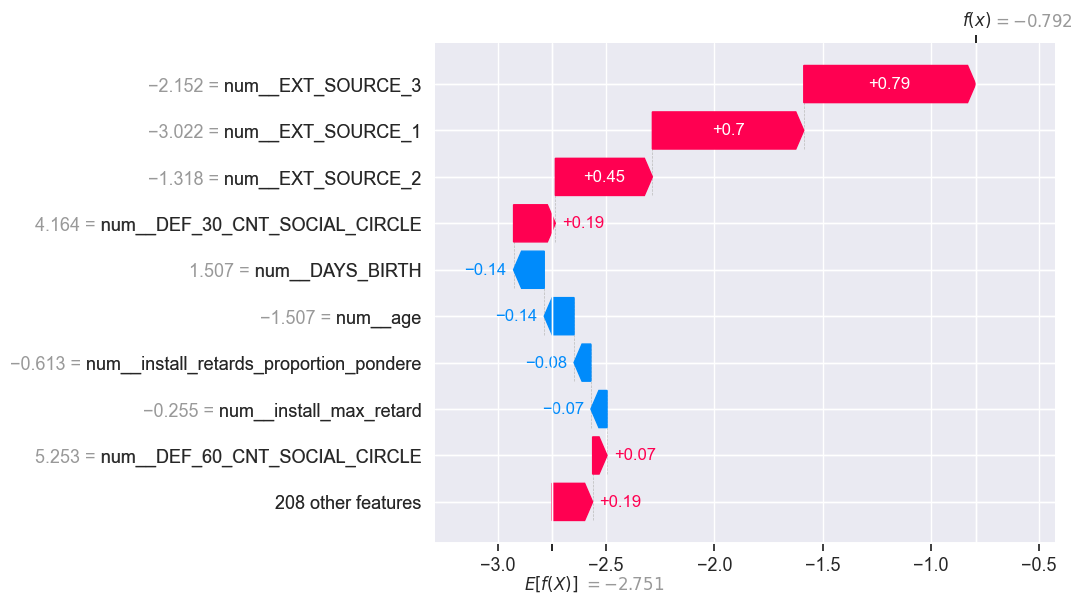

In [17]:
# Étape 1 : accéder au modèle et aux noms de features
model = model_pd_light.named_steps["model"]
feature_names = model_pd_light.named_steps["preprocessing"].get_feature_names_out()

# Étape 2 : importer les importances et afficher les plus importantes
importances = model.feature_importances_

feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp.sort_values(by="importance", ascending=False).head(20).plot.bar(
    x="feature", y="importance", figsize=(10, 5)
)
plt.title("Top 20 features – LightGBM")
plt.grid()
plt.tight_layout()
plt.show()

# Étape 3 : transformer X en DataFrame pour récupérer le nom des variables
X_transformed = pd.DataFrame(
    model_pd_light.named_steps["preprocessing"].transform(X),
    columns=model_pd_light.named_steps["preprocessing"].get_feature_names_out(),
    index=X.index
)

# Étape 4 : SHAP
explainer = shap.Explainer(model, X_transformed)
shap_values = explainer(X_transformed, check_additivity=False)

shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.waterfall(shap_values[0])

### 1. Top 20 features (barplot)
Ce graphique présente les 20 variables les plus importantes selon LightGBM. On y retrouve :

- `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3` : scores externes agrégés indiquant la stabilité ou le risque du client.
- `AMT_ANNUITY`, `ratio_credit_goods`, `retards_proportion_pondéré` : variables financières liées aux crédits passés.
- `buro_avg_debt_ratio`, `prev_taux_refus` : indicateurs du comportement historique de crédit.

> Ces variables sont celles qui contribuent le plus à la capacité prédictive du modèle. Leur importance est mesurée selon le gain moyen qu'elles apportent dans les arbres de décision.

---

### 2. SHAP – Beeswarm plot (importance globale)
Le beeswarm plot SHAP montre :
- **l’importance globale** de chaque variable sur l’ensemble des prédictions,
- **la direction de l’impact** (positif = augmentation du risque),
- **la valeur de la variable** (rouge = valeur élevée, bleu = valeur faible).

**Exemples** :
- Une **valeur faible de `EXT_SOURCE_2`** (en bleu) tend à **augmenter le risque de défaut**.
- Un **taux d’utilisation élevé des cartes** augmente fortement le risque (`cc_taux_utilisation_pondéré`).
- Le **genre masculin (`CODE_GENDER_M`)** semble légèrement associé à un risque accru.

> SHAP apporte une explication fine : il ne dit pas seulement *quelles* variables sont importantes, mais *comment* elles influencent la prédiction.

---

### 3. SHAP – Waterfall plot (explication locale)
Ce graphique montre l’effet de chaque variable sur la prédiction **d’un individu en particulier** :

- Les flèches bleues poussent la prédiction vers 0 (non-défaillance), les rouges vers 1 (défaillance).
- Exemple :
  - `NAME_EDUCATION_TYPE_Higher education` réduit le risque (effet bleu).
  - Un **taux d’utilisation élevé des cartes** ou une **valeur faible de `EXT_SOURCE_3`** augmente le risque.

> Ce type de visualisation est particulièrement utile pour justifier une décision d’octroi ou de refus de crédit à un client.

---

### Conclusion

- Les scores externes (`EXT_SOURCE_x`) dominent largement en importance.
- Les variables issues des historiques de crédit (`bureau`, `installments`, `previous`) et certains attributs socio-économiques sont également très influents.
- **SHAP** permet une interprétation transparente, à la fois **globale** (beeswarm) et **locale** (waterfall), rendant le modèle **plus explicable** et **plus conforme aux attentes réglementaires** dans le secteur bancaire.

## 8. Sauvegarde du modèle

In [18]:
joblib.dump(model_pd_light, "model_pd.pkl")

['model_pd.pkl']